In [22]:
from machine_learning.utility import show
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

MNSIT Dataset

In [23]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [24]:
X, y = mnist["data"], mnist["target"]

show(Data = X.shape,
     Target = y.shape)


Data: 
 (70000, 784)

Target: 
 (70000,)


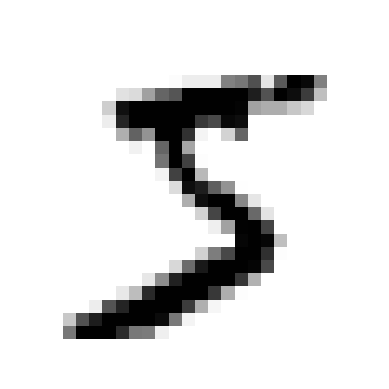

In [25]:
some_digits = X.iloc[0].to_numpy()
some_digit_image = some_digits.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

y = y.astype(np.uint8)

In [26]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Binary classifier

making : The "5" detector

In [27]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

Stochastic Gradient Descent (SGD)

In [28]:
from sklearn.linear_model import SGDClassifier

sgd_clff = SGDClassifier(random_state = 42)
sgd_clff.fit(X_train, y_train_5)

,"loss loss: {'hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'}, default='hinge'The loss function to be used.- 'hinge' gives a linear SVM.- 'log_loss' gives logistic regression, a probabilistic classifier.- 'modified_huber' is another smooth loss that brings tolerance to outliers as well as probability estimates.- 'squared_hinge' is like hinge but is quadratically penalized.- 'perceptron' is the linear loss used by the perceptron algorithm.- The other losses, 'squared_error', 'huber', 'epsilon_insensitive' and 'squared_epsilon_insensitive' are designed for regression but can be useful in classification as well; see :class:`~sklearn.linear_model.SGDRegressor` for a description.More details about the losses formulas can be found in the :ref:`User Guide` and you can find a visualisation of the lossfunctions in:ref:`sphx_glr_auto_examples_linear_model_plot_sgd_loss_functions.py`.",'hinge'
,"penalty penalty: {'l2', 'l1', 'elasticnet', None}, default='l2'The penalty (aka regularization term) to be used. Defaults to 'l2'which is the standard regularizer for linear SVM models. 'l1' and'elasticnet' might bring sparsity to the model (feature selection)not achievable with 'l2'. No penalty is added when set to `None`.You can see a visualisation of the penalties in:ref:`sphx_glr_auto_examples_linear_model_plot_sgd_penalties.py`.",'l2'
,"alpha alpha: float, default=0.0001Constant that multiplies the regularization term. The higher thevalue, the stronger the regularization. Also used to compute thelearning rate when `learning_rate` is set to 'optimal'.Values must be in the range `[0.0, inf)`.",0.0001
,"l1_ratio l1_ratio: float, default=0.15The Elastic Net mixing parameter, with 0 <= l1_ratio <= 1.l1_ratio=0 corresponds to L2 penalty, l1_ratio=1 to L1.Only used if `penalty` is 'elasticnet'.Values must be in the range `[0.0, 1.0]` or can be `None` if`penalty` is not `elasticnet`... versionchanged:: 1.7 `l1_ratio` can be `None` when `penalty` is not ""elasticnet"".",0.15
,"fit_intercept fit_intercept: bool, default=TrueWhether the intercept should be estimated or not. If False, thedata is assumed to be already centered.",True
,"max_iter max_iter: int, default=1000The maximum number of passes over the training data (aka epochs).It only impacts the behavior in the ``fit`` method, and not the:meth:`partial_fit` method.Values must be in the range `[1, inf)`... versionadded:: 0.19",1000
,"tol tol: float or None, default=1e-3The stopping criterion. If it is not None, training will stopwhen (loss > best_loss - tol) for ``n_iter_no_change`` consecutiveepochs.Convergence is checked against the training loss or thevalidation loss depending on the `early_stopping` parameter.Values must be in the range `[0.0, inf)`... versionadded:: 0.19",0.001
,"shuffle shuffle: bool, default=TrueWhether or not the training data should be shuffled after each epoch.",True
,"verbose verbose: int, default=0The verbosity level.Values must be in the range `[0, inf)`.",0
,"epsilon epsilon: float, default=0.1Epsilon in the epsilon-insensitive loss functions; only if `loss` is'huber', 'epsilon_insensitive', or 'squared_epsilon_insensitive'.For 'huber', determines the threshold at which it becomes lessimportant to get the prediction exactly right.For epsilon-insensitive, any differences between the current predictionand the correct label are ignored if they are less than this threshold.Values must be in the range `[0.0, inf)`.",0.1
,"n_jobs n_jobs: int, default=NoneThe number of CPUs to use to do the OVA (One Versus All, formulti-class problems) computation.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None


In [29]:
sgd_clff.predict([some_digits])

d:\Anaconda\envs\train\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

### Performance measure

using cross-validation

In [30]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3,shuffle=True, random_state=42)


for train_index, test_index in skfolds.split(X_train, y_train_5): 
    clone_clf = clone(sgd_clff) 
    X_train_folds = X_train.iloc[train_index] 
    y_train_folds = y_train_5.iloc[train_index] 
    X_test_fold = X_train.iloc[test_index] 
    y_test_fold = y_train_5.iloc[test_index] 
 
    clone_clf.fit(X_train_folds, y_train_folds) 
    y_pred = clone_clf.predict(X_test_fold) 
    n_correct = sum(y_pred == y_test_fold) 
    print(n_correct / len(y_pred))

0.9042
0.9477
0.96785


In [31]:
from sklearn.model_selection import cross_val_score 
cross_val_score(sgd_clff, X_train, y_train_5, cv=3, scoring="accuracy") 

array([0.95035, 0.96035, 0.9604 ])

In [32]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [33]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [34]:
# Even random guess gives you a chance of 90% accuracy just by chance.. 
# Because of the skewed proportions of data..
# i.e. 5s are 10% of dataset ..whereas.. not-5s cover 90% of dataset

# Hence use confusion matrix for better metrics

Confusion matrix

In [35]:
from sklearn.model_selection import cross_val_predict

cross_predicted = cross_val_predict(sgd_clff, X_train, y_train_5, cv=3)

In [36]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5,cross_predicted)

array([[53892,   687],
       [ 1891,  3530]])

In [37]:
# For example
y_train_perfect_predictions = y_train_5  # pretend we reached perfection 
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [38]:
# Precision and recall
from sklearn.metrics import precision_score, recall_score

rec_score = recall_score(y_train_5, cross_predicted)
prec_score = precision_score(y_train_5, cross_predicted)

show(recall = rec_score,
     precision = prec_score)


recall: 
 0.6511713705958311

precision: 
 0.8370879772350012


In [39]:
# ehh just calculate the f1 score instead!
from sklearn.metrics import f1_score


show(f1_Score = f1_score(y_train_5, cross_predicted))


f1_Score: 
 0.7325171197343847


Threshold

In [40]:
y_scores = sgd_clff.decision_function([some_digits])
show(scores = y_scores)

threshold = 0
something = (y_scores > threshold)
show(something = something)


scores: 
 [2164.22030239]

something: 
 [ True]


d:\Anaconda\envs\train\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


In [41]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

How to decide threshold

In [44]:
from sklearn.metrics import precision_recall_curve
y_scores = cross_val_predict(sgd_clff, X_train, y_train_5, cv = 3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_5,y_scores)

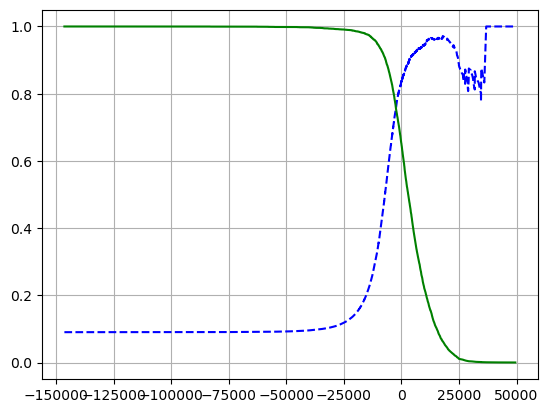

In [56]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.grid(True)
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [58]:
threshold_90_precision = thresholds[np.argmax(precisions >=  0.90)]
threshold_90_precision

np.float64(3370.0194991439594)

In [65]:
y_train_5_pred = (y_scores >= threshold_90_precision)
precision_5 = precision_score(y_train_5, y_train_5_pred)
recall_5 = recall_score(y_train_5, y_train_5_pred)
show(precision = precision_5,
     recall = recall_5)


precision: 
 0.9000345901072293

recall: 
 0.4799852425751706


ROC curve 
--->Checking True Positive rates (AKA recall)

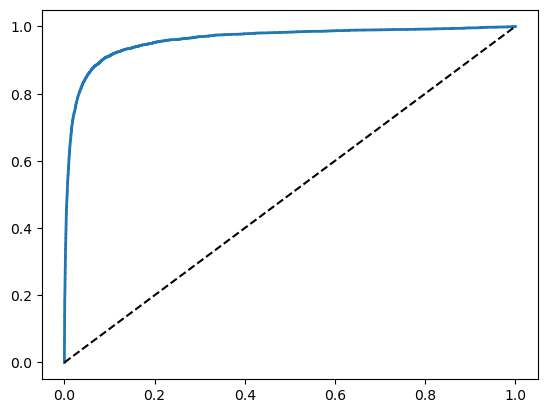

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores) 

def plot_roc_curve(fpr, tpr, label=None): 
    plt.plot(fpr, tpr, linewidth=2, label=label) 
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal  
    plt.legend("")
plot_roc_curve(fpr, tpr)
plt.show()

In [72]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

##### Random Forest Classifier

In [73]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method = "predict_proba")


In [76]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

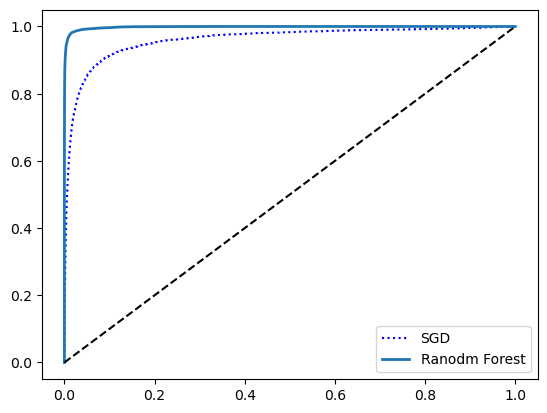

In [78]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, label="Ranodm Forest")
plt.legend(loc="lower right")
plt.show()

In [80]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

## Multi-Class Classification

Support vector machine classifer

In [84]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digits])

d:\Anaconda\envs\train\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)